In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DRDataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3662 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 4 3 2 1 2 0 2 2 0 2 2 0 2 2 2 1 1 2 0 1 2 1 1 1 2 2 2 0 2 2 2]


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]

 [[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]

 [[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]

 ...

 [[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]

 [[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]

 [[128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [128. 128. 128.]
  [128. 128. 128.]]], shape=(224, 224, 3), dtype=float32)


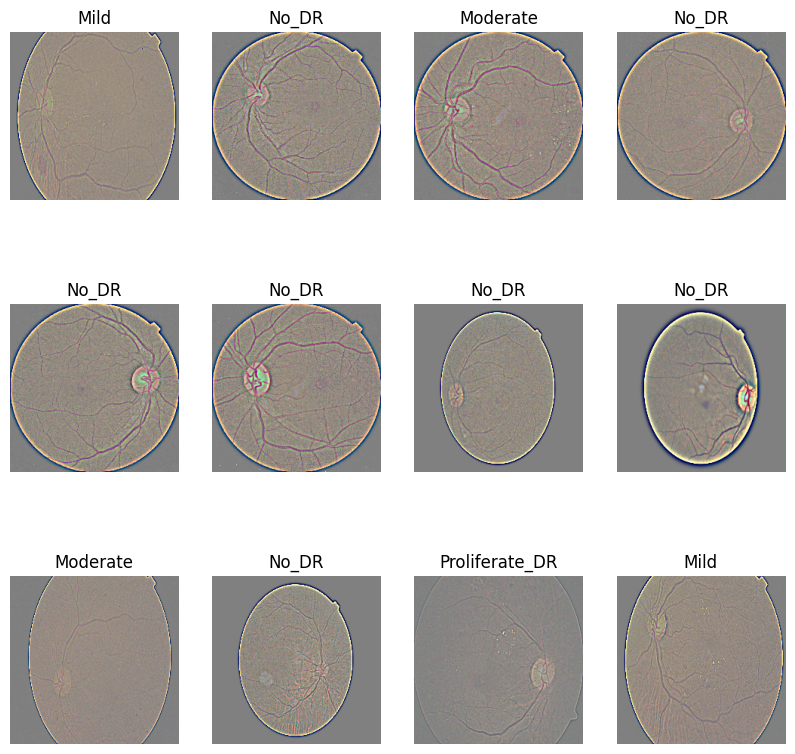

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split* ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

92

In [11]:
len(val_ds)

11

In [12]:
len(test_ds)

12

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [19]:
EPOCHS = 50

In [20]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
92/92 [==============================] - 128s 1s/step - loss: 1.1986 - accuracy: 0.5181 - val_loss: 1.3974 - val_accuracy: 0.4517
Epoch 2/50
92/92 [==============================] - 126s 1s/step - loss: 1.0159 - accuracy: 0.6353 - val_loss: 1.1161 - val_accuracy: 0.6193
Epoch 3/50
92/92 [==============================] - 124s 1s/step - loss: 0.9627 - accuracy: 0.6463 - val_loss: 1.0585 - val_accuracy: 0.6165
Epoch 4/50
92/92 [==============================] - 127s 1s/step - loss: 0.9237 - accuracy: 0.6681 - val_loss: 1.0303 - val_accuracy: 0.6136
Epoch 5/50
92/92 [==============================] - 113s 1s/step - loss: 0.8768 - accuracy: 0.6822 - val_loss: 1.0688 - val_accuracy: 0.5824
Epoch 6/50
92/92 [==============================] - 125s 1s/step - loss: 0.8458 - accuracy: 0.6965 - val_loss: 1.0413 - val_accuracy: 0.6392
Epoch 7/50
92/92 [==============================] - 118s 1s/step - loss: 0.8275 - accuracy: 0.7030 - val_loss: 1.0357 - val_accuracy: 0.6506
Epoch 8/50
92

92/92 [==============================] - 113s 1s/step - loss: 0.5605 - accuracy: 0.7857 - val_loss: 1.0765 - val_accuracy: 0.6790
Epoch 42/50
92/92 [==============================] - 121s 1s/step - loss: 0.5640 - accuracy: 0.7823 - val_loss: 1.0885 - val_accuracy: 0.6364
Epoch 43/50
92/92 [==============================] - 116s 1s/step - loss: 0.5721 - accuracy: 0.7840 - val_loss: 1.0701 - val_accuracy: 0.6364
Epoch 44/50
92/92 [==============================] - 110s 1s/step - loss: 0.5712 - accuracy: 0.7826 - val_loss: 1.0415 - val_accuracy: 0.6591
Epoch 45/50
92/92 [==============================] - 115s 1s/step - loss: 0.5618 - accuracy: 0.7888 - val_loss: 0.9163 - val_accuracy: 0.7045
Epoch 46/50
92/92 [==============================] - 113s 1s/step - loss: 0.5524 - accuracy: 0.7867 - val_loss: 1.0051 - val_accuracy: 0.6790
Epoch 47/50
92/92 [==============================] - 110s 1s/step - loss: 0.5600 - accuracy: 0.7802 - val_loss: 1.0467 - val_accuracy: 0.6676
Epoch 48/50
92/92 

In [21]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 6s 257ms/step - loss: 0.9833 - accuracy: 0.6380


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

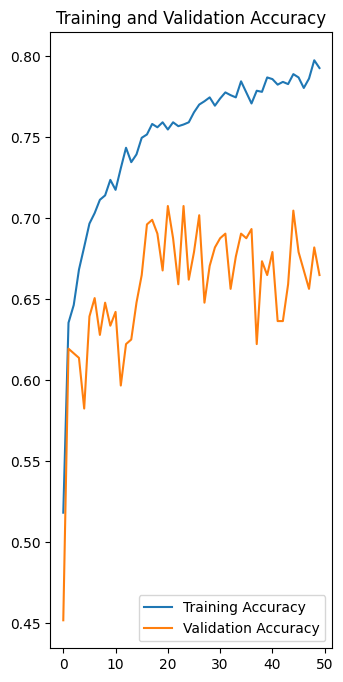

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

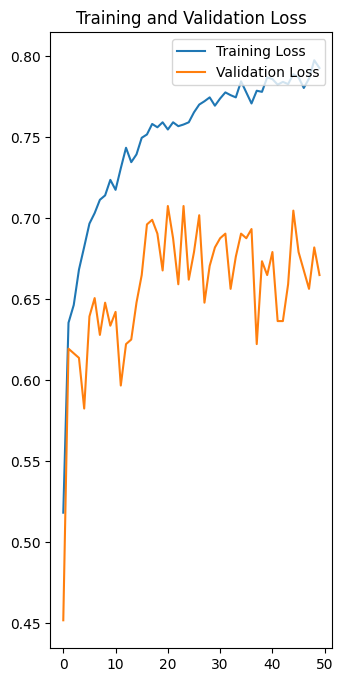

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Moderate
1/1 [==============================] - 1s 824ms/step
predicted label: Moderate


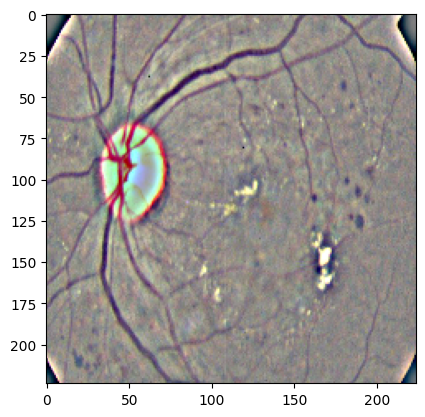

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


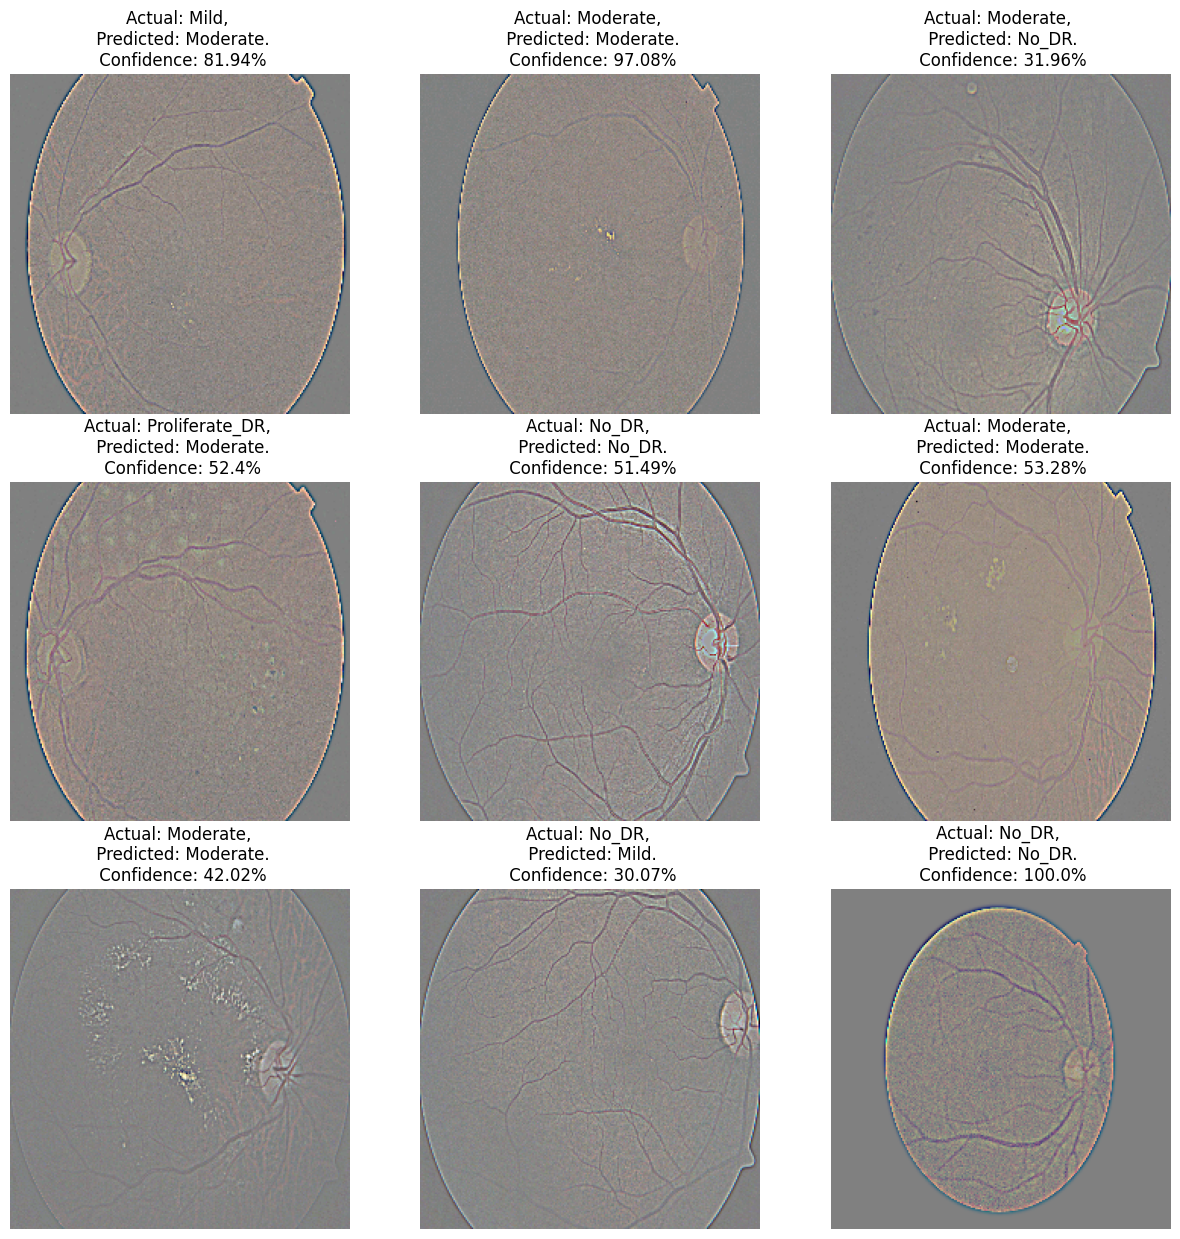

In [27]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%" )
        plt.axis("off")

In [28]:
model_version = 3
model.save(f"../saved_model/{model_version}")

INFO:tensorflow:Assets written to: ../saved_model/3\assets


INFO:tensorflow:Assets written to: ../saved_model/3\assets
